<a href="https://colab.research.google.com/github/julienroy13/competitive_gradient_descent/blob/master/gan_gda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GAN Training code referenced
 from: https://github.com/afiliot/GANs-And-VAEs-For-Gaussian-Mixture/blob/master/DLIP-MP1-GAN-VAE-FILIOT.ipynb

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from torch.distributions.multivariate_normal import MultivariateNormal

from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



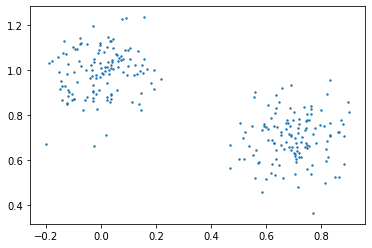

In [102]:
def generate_batch(batchlen,plot=False):
  
  cov = torch.tensor(np.identity(2)*0.01, dtype=torch.float64)
  mu1 = torch.tensor([2**(-1/2), 2**(-1/2)], dtype=torch.float64)
  mu2 = torch.tensor([0,1], dtype=torch.float64)
  
  gaussian1 = MultivariateNormal(loc=mu1, covariance_matrix=cov)
  gaussian2 = MultivariateNormal(loc=mu2, covariance_matrix=cov)

  data = []
  d1 = gaussian1.rsample((int(batchlen/2),))
  d2 = gaussian2.rsample((int(batchlen/2),))

  data = np.concatenate((d1, d2), axis=0)
  np.random.shuffle(data)

  if plot:
    plt.scatter(data[:,0],data[:,1], s=2.0)
  return torch.Tensor(data).to(device)

batch = generate_batch(256, plot=True)


In [0]:
# Define the generator
class Generator(nn.Module):
    def __init__(self, hidden_size=0, noise_size=1, noise_std=1.):
        super().__init__()
        self.noise_size = noise_size
        self.noise_std = noise_std

        # First layer
        self.fc1 = nn.Linear(noise_size, hidden_size)

        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, hidden_size)

        self.fc6 = nn.Linear(hidden_size, 2)


    def __call__(self, z):
        h = F.relu(self.fc1(z))

        h = F.relu(self.fc2(h))
        h = F.relu(self.fc3(h))
        h = F.relu(self.fc4(h))
        h = F.relu(self.fc5(h))

        return self.fc6(h)

    
    def generate(self, batchlen):
        z = torch.normal(torch.zeros(batchlen, self.noise_size), self.noise_std)
        return self.__call__(z)
    

# Define the discriminator.
class Discriminator(nn.Module):
    def __init__(self, hidden_size=0):
        super().__init__()

        self.fc1 = nn.Linear(2, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, hidden_size)
        self.fc6 = nn.Linear(hidden_size, 1)


    
    def __call__(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        # return torch.sigmoid(self.fc6(x))
        return self.fc6(x)


In [0]:
def GAN(TRAIN_RATIO=1, N_ITER=5000, BATCHLEN=128,
        hidden_size_G=0, hidden_size_D=0,
        noise_size=1, noise_std=1., frame=1000):
    """
    TRAIN_RATIO : int, number of times to train the discriminator between two generator steps
    N_ITER : int, total number of training iterations for the generator
    BATCHLEN : int, Batch size to use
    hidden_size_G : int, width of the generator (number of neurons in hidden layers)
    hidden_size_D : int, width of the discriminator (number of neurons in hidden layers)
    noise_size : int, dimension of input noise
    noise_std : float, standard deviation of p(z)
    frame : int, display data each 'frame' iteration
    """

    G = Generator(hidden_size=hidden_size_G, noise_size=noise_size, noise_std=noise_std)
    solver_G = torch.optim.SGD(G.parameters(), lr=1e-3)
    D = Discriminator(hidden_size=hidden_size_D)
    solver_D = torch.optim.SGD(D.parameters(), lr=1e-4)

    for i in tqdm(range(N_ITER)):
        # train the discriminator
        for _ in range(TRAIN_RATIO):
            D.zero_grad()
            real_batch = generate_batch(BATCHLEN)
            fake_batch = G.generate(BATCHLEN)

            # Compute here the discriminator loss, using functions like torch.sum, torch.exp, torch.log,
            # torch.softplus, using real_batch and fake_batch
            h_real = D(real_batch)
            h_fake = D(fake_batch)
            loss_real = torch.mean(torch.sum(F.softplus(-h_real)))
            loss_fake = torch.mean(torch.sum(F.softplus(h_fake)))
            disc_loss = loss_real + loss_fake
            disc_loss.backward()
            solver_D.step()
        # train the generator
        G.zero_grad()
        fake_batch = G.generate(BATCHLEN)
        # Compute here the generator loss, using fake_batch
        h_fake = D(fake_batch)
        gen_loss = - torch.mean(torch.sum(F.softplus(h_fake)))
        gen_loss.backward()
        solver_G.step()
        if i%frame == 0:
            print('step {}: discriminator: {:.3e}, generator: {:.3e}'.format(i, float(disc_loss), float(gen_loss)))
            # plot the result
            real_batch = generate_batch(1024)
            fake_batch = G.generate(1024).detach()
            plt.scatter(real_batch[:,0], real_batch[:,1], s=2.0, label='real data')
            plt.scatter(fake_batch[:,0], fake_batch[:,1], s=2.0, label='fake data')
            plt.show()

step 0: discriminator: 1.775e+02, generator: -8.798e+01


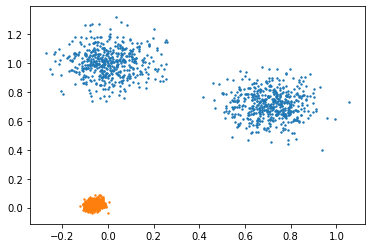

step 100: discriminator: 1.761e+02, generator: -8.994e+01


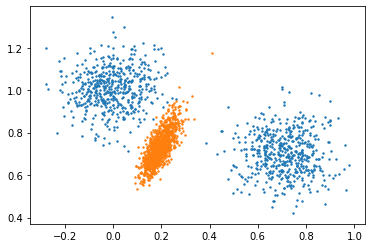

step 200: discriminator: 1.774e+02, generator: -8.807e+01


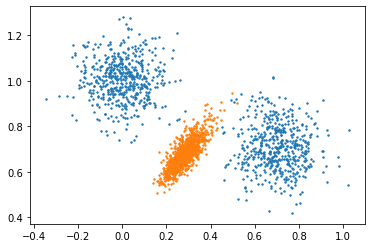

step 300: discriminator: 1.767e+02, generator: -8.789e+01


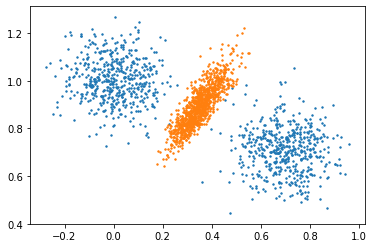

step 400: discriminator: 1.785e+02, generator: -9.042e+01


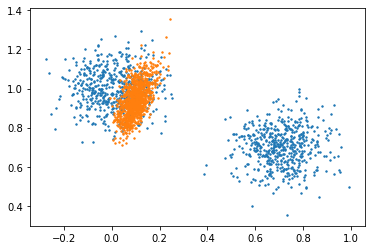

step 500: discriminator: 1.776e+02, generator: -8.877e+01


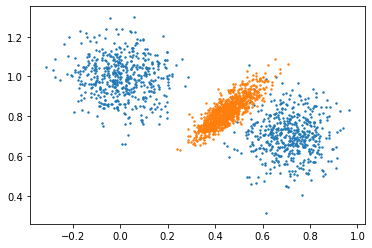

step 600: discriminator: 1.773e+02, generator: -8.891e+01


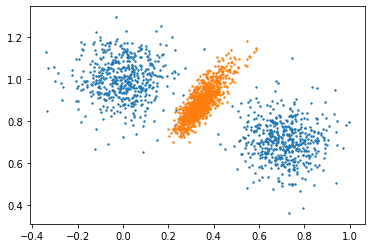

step 700: discriminator: 1.767e+02, generator: -8.780e+01


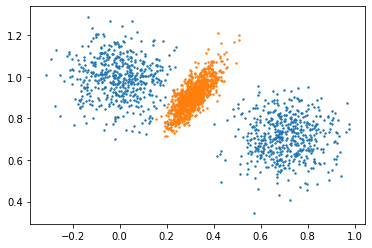

step 800: discriminator: 1.778e+02, generator: -8.946e+01


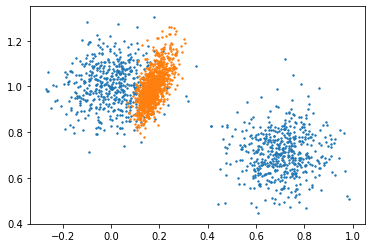

step 900: discriminator: 1.789e+02, generator: -8.991e+01


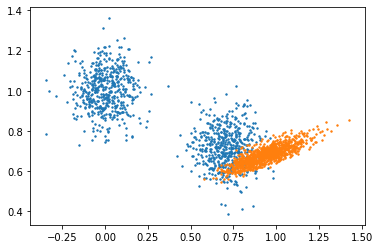

step 1000: discriminator: 1.778e+02, generator: -8.920e+01


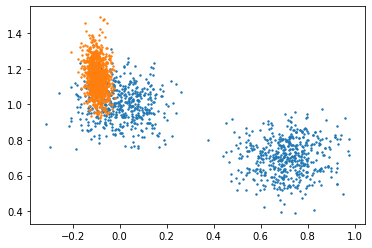

step 1100: discriminator: 1.769e+02, generator: -8.771e+01


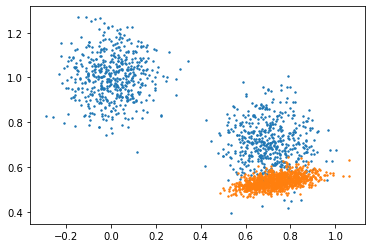

step 1200: discriminator: 1.758e+02, generator: -8.769e+01


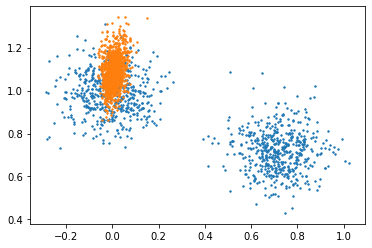

step 1300: discriminator: 1.775e+02, generator: -8.958e+01


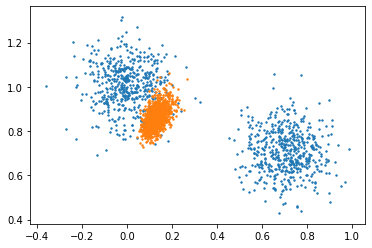

step 1400: discriminator: 1.773e+02, generator: -8.673e+01


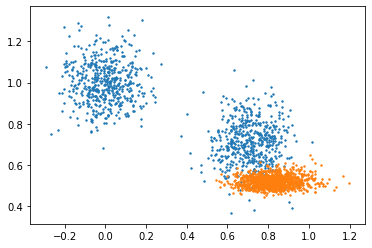

step 1500: discriminator: 1.759e+02, generator: -8.810e+01


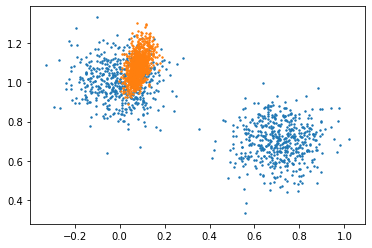

step 1600: discriminator: 1.778e+02, generator: -8.949e+01


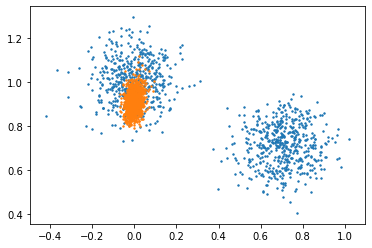

step 1700: discriminator: 1.761e+02, generator: -8.717e+01


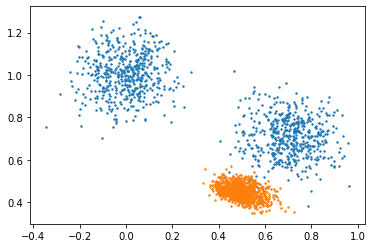

step 1800: discriminator: 1.790e+02, generator: -8.804e+01


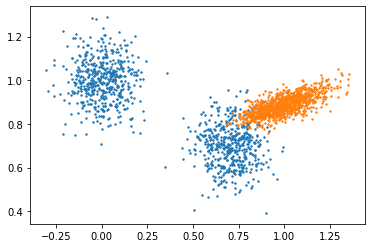

step 1900: discriminator: 1.741e+02, generator: -8.819e+01


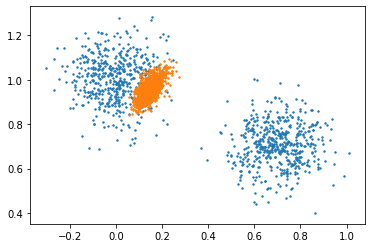

step 2000: discriminator: 1.726e+02, generator: -8.708e+01


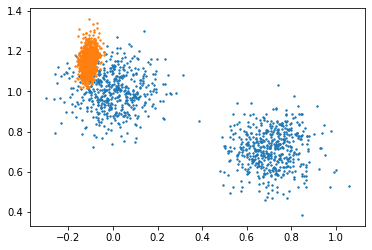

step 2100: discriminator: 1.745e+02, generator: -8.912e+01


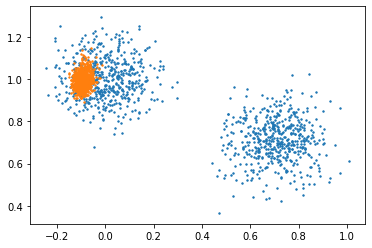

step 2200: discriminator: 1.692e+02, generator: -8.759e+01


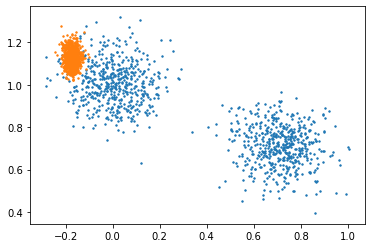

step 2300: discriminator: 1.702e+02, generator: -8.852e+01


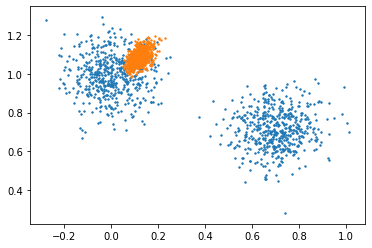

step 2400: discriminator: 1.901e+02, generator: -9.629e+01


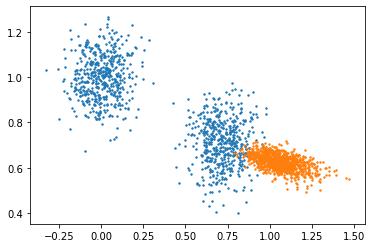

step 2500: discriminator: 1.762e+02, generator: -8.276e+01


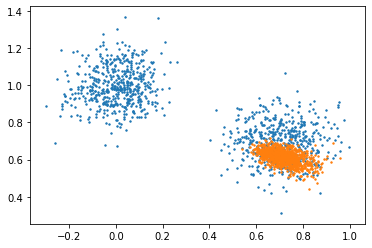

step 2600: discriminator: 1.742e+02, generator: -8.393e+01


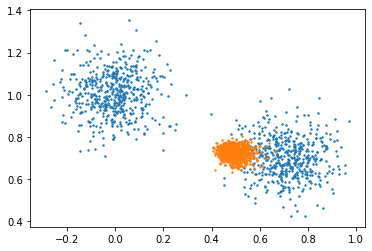

step 2700: discriminator: 1.680e+02, generator: -8.927e+01


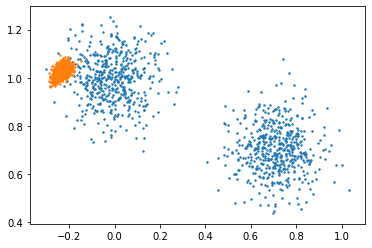

step 2800: discriminator: 1.789e+02, generator: -7.571e+01


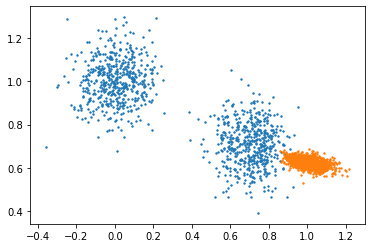

step 2900: discriminator: 1.734e+02, generator: -8.198e+01


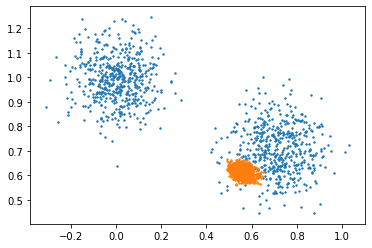

step 3000: discriminator: 1.766e+02, generator: -8.780e+01


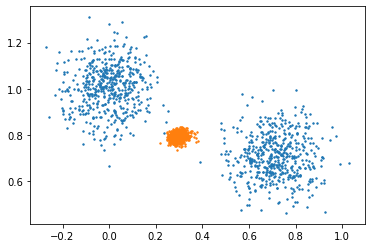

step 3100: discriminator: 1.795e+02, generator: -8.964e+01


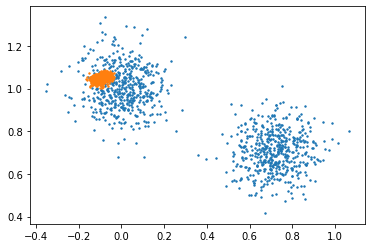

step 3200: discriminator: 1.354e+02, generator: -7.816e+01


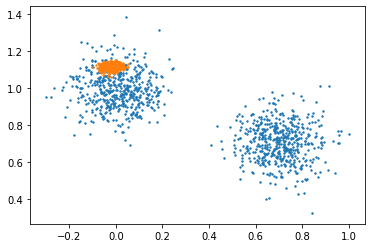

step 3300: discriminator: 1.797e+02, generator: -8.297e+01


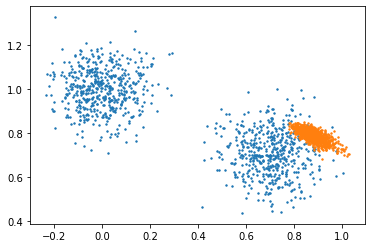

step 3400: discriminator: 1.808e+02, generator: -8.534e+01


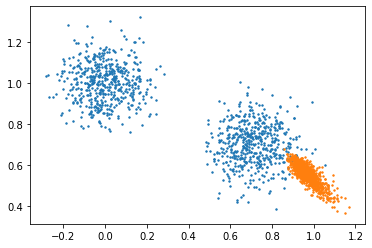

step 3500: discriminator: 1.736e+02, generator: -8.520e+01


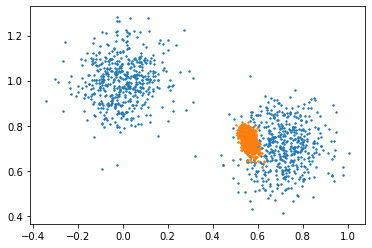

step 3600: discriminator: 1.766e+02, generator: -8.777e+01


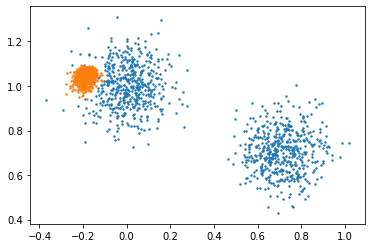

step 3700: discriminator: 1.753e+02, generator: -7.879e+01


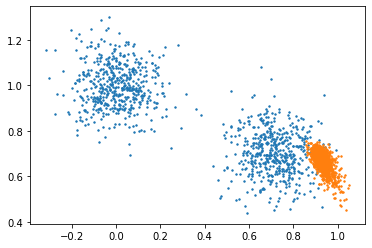

step 3800: discriminator: 1.773e+02, generator: -8.863e+01


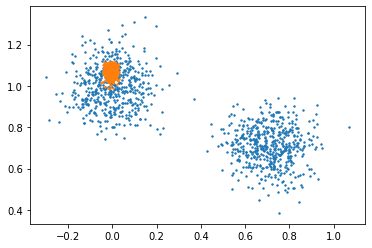

step 3900: discriminator: 1.730e+02, generator: -8.195e+01


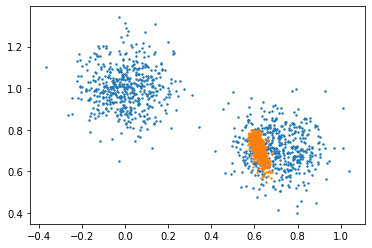

step 4000: discriminator: 1.370e+02, generator: -7.962e+01


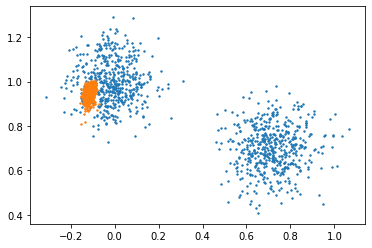

step 4100: discriminator: 1.859e+02, generator: -9.322e+01


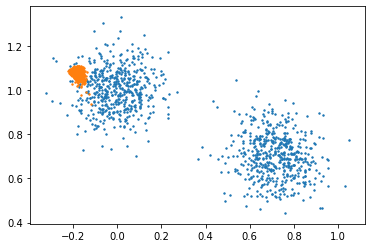

step 4200: discriminator: 1.688e+02, generator: -8.350e+01


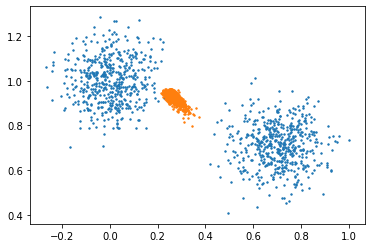

step 4300: discriminator: 1.597e+02, generator: -7.443e+01


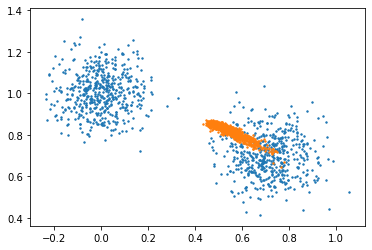

step 4400: discriminator: 1.589e+02, generator: -7.513e+01


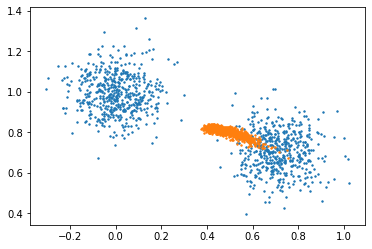

step 4500: discriminator: 1.918e+02, generator: -9.864e+01


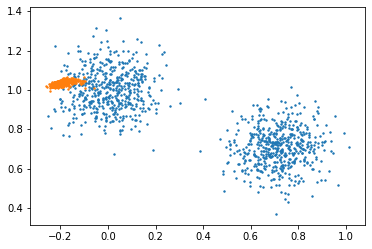

step 4600: discriminator: 1.202e+02, generator: -6.456e+01


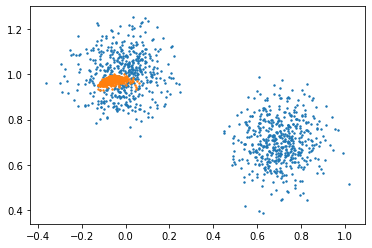

step 4700: discriminator: 1.577e+02, generator: -6.661e+01


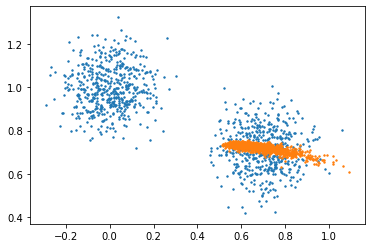

step 4800: discriminator: 1.321e+02, generator: -6.715e+01


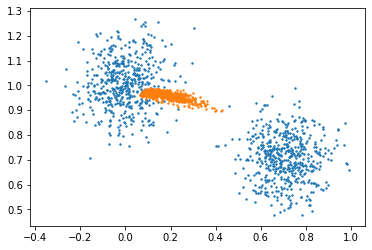

step 4900: discriminator: 1.353e+02, generator: -6.393e+01


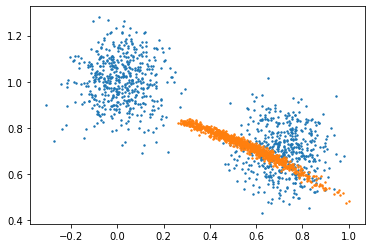

In [112]:
GAN(TRAIN_RATIO=2, N_ITER=5000, BATCHLEN=128,
    hidden_size_G=128, hidden_size_D=128,
    noise_size=512, noise_std=6, frame=100)